In [1]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [16,9]
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import *
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc

import theano
theano.config.compute_test_value = "ignore"

import pandas as pd
import numpy as np


Using TensorFlow backend.


In [10]:
def shuffle_in_unison(a, b):
    # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

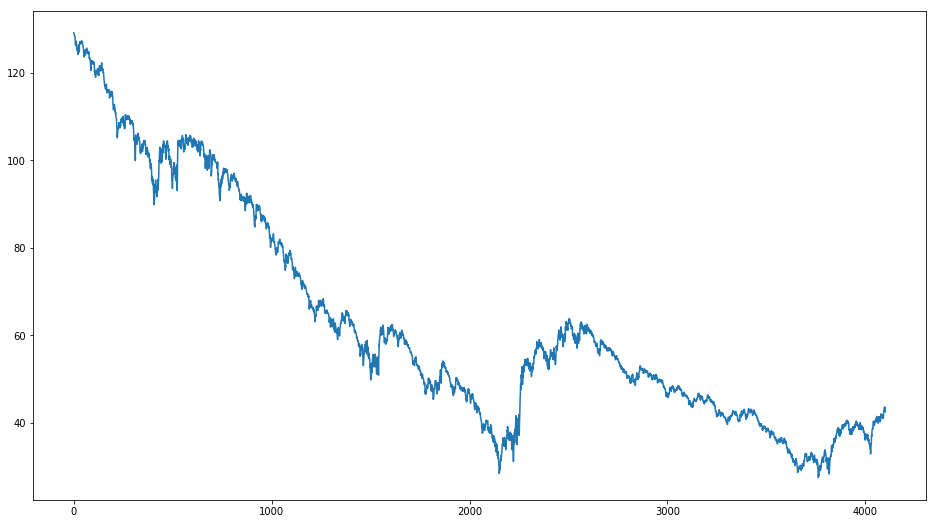

list index out of range


In [11]:
data = pd.read_csv('stockdatas/VTI.csv')[::-1]
data = data.loc[:, 'adjClose'].tolist()

# Uncomment below to use price instead time series
# data = data.loc[:, 'adjClose'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 120
EMB_SIZE = 1
STEP = 1
FORECAST = 20

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [14]:
# https://keras.io/optimizers/
# https://keras.io/activations/

model = Sequential()
model.add(Dense(64, input_dim=120,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('linear'))

opt = Adam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, Y_train, 
          epochs = 5, 
          batch_size = 128, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)



Train on 3566 samples, validate on 397 samples
Epoch 1/5
Epoch 00000: val_loss did not improve
0s - loss: 33.2602 - acc: 0.4753 - val_loss: 40.0483 - val_acc: 0.5315
Epoch 2/5
Epoch 00001: val_loss did not improve
0s - loss: 27.3728 - acc: 0.4804 - val_loss: 32.0588 - val_acc: 0.5340
Epoch 3/5
Epoch 00002: val_loss did not improve
0s - loss: 27.0736 - acc: 0.4683 - val_loss: 32.4021 - val_acc: 0.5290
Epoch 4/5
Epoch 00003: val_loss did not improve
0s - loss: 23.7458 - acc: 0.4776 - val_loss: 26.4228 - val_acc: 0.4962
Epoch 5/5
Epoch 00004: val_loss did not improve
0s - loss: 20.5840 - acc: 0.4762 - val_loss: 23.5649 - val_acc: 0.5214


In [17]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("\nModel Accuracy: %.2f%%" % (scores[1]*100))

 32/397 [=>............................] - ETA: 0s
Model Accuracy: 52.14%


In [18]:
plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

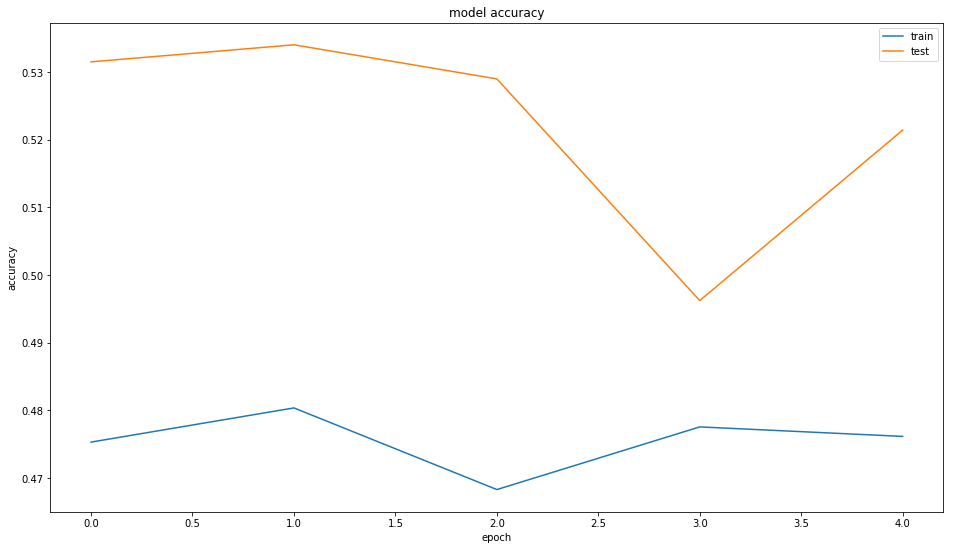

In [19]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predicting on test data
Generating results


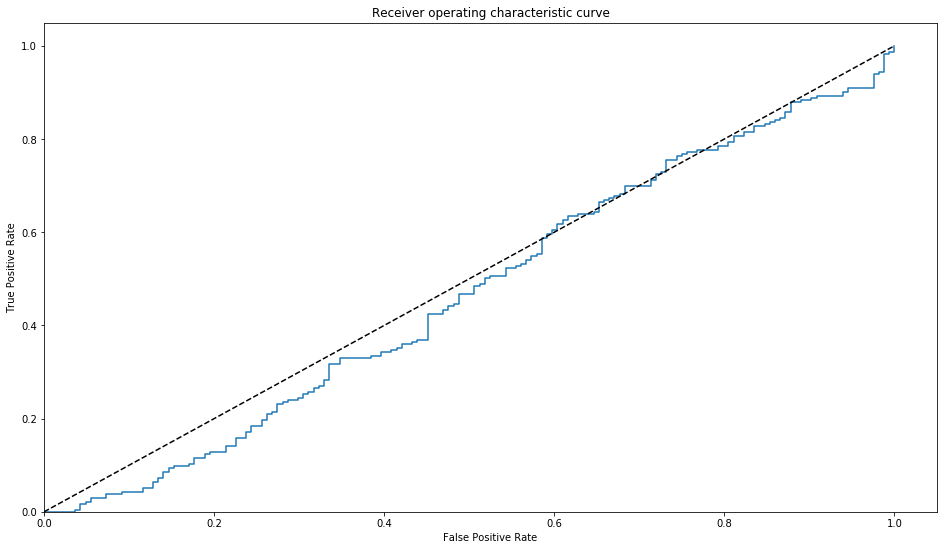

AUC: 0.468151


In [20]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)
    
print('Predicting on test data')
y_score = model.predict(X_test)

print('Generating results')
generate_results(Y_test[:, 0], y_score[:, 0])